# Predict time series using trained model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
import keras.backend as K

Using TensorFlow backend.


In [2]:
data_folder = '../Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

- import **deephydro module** with networks, losses and metrics

In [3]:
%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

from deephydro.utils import limit_gpu_memory
limit_gpu_memory()

# Data import

- load output data

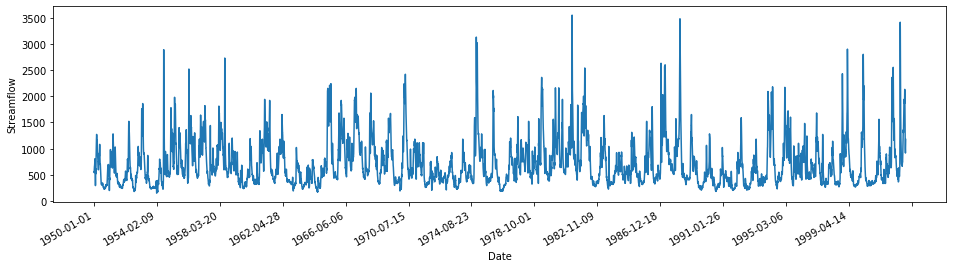

In [4]:
from deephydro import data, visualization
df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df, n_labels=20)

- load input data

In [5]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)

In [6]:
print(f'x_prec.shape = {x_prec.shape}')
print(f'x_temp.shape = {x_temp.shape}')
print(f'x_mask.shape = {x_mask.shape}')

x_prec.shape = (19358, 53, 66)
x_temp.shape = (19358, 53, 66)
x_mask.shape = (53, 66)


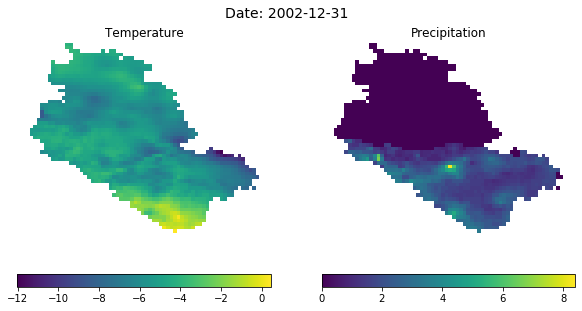

In [7]:
visualization.plot_temp_prec_frame(x_temp, x_prec, x_mask, df, 
                                   frame=-1)


# Data preparation

- define input data `x` and targets `y`

In [8]:
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

- split train and validation data

In [9]:
# split train and validation data
validation_fraction=0.2
validation_first=False

x_train, x_val, y_train, y_val = \
  data.split_train_validation(x, y, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

x_doy_train, x_doy_val = data.split_DOY_train_validation(x_doy,  
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)

df_train, df_val = data.split_df_train_validation(df, 
                              validation_fraction=validation_fraction,
                              validation_first=validation_first)


In [10]:
print('Shape of x_train = ', x_train.shape)
print('Shape of y_train = ', y_train.shape)
print('Shape of x_val   = ', x_val.shape)
print('Shape of y_val   = ', y_val.shape)

Shape of x_train =  (15487, 53, 66, 2)
Shape of y_train =  (15487,)
Shape of x_val   =  (3871, 53, 66, 2)
Shape of y_val   =  (3871,)


- standardize input (`x_train`) and output data (`y`)

In [11]:
x_train = data.standardize_input_data(x_train)
x_val   = data.standardize_input_data(x_val)

In [12]:
y_train, (Y_MEAN, Y_STD) = data.standardize_targets(y_train)
y_val = (y_val - Y_MEAN) / Y_STD

In [13]:
print(f'Y_MEAN = {Y_MEAN:.3f}')
print(f'Y_STD  = {Y_STD:.3f}')
print('Shape of y = ', y_train.shape)


Y_MEAN = 715.437
Y_STD  = 426.762
Shape of y =  (15487,)


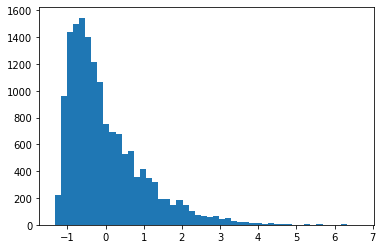

In [14]:
_ = plt.hist(y_train, bins=50)

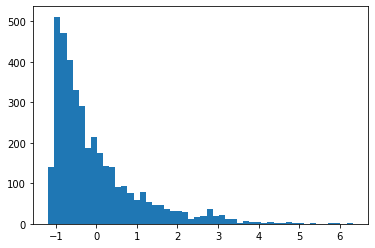

In [15]:
_ = plt.hist(y_val, bins=50)

# Predict

In [16]:
model_name = '../output/model_wdb_uncertainty.h5'

n_frames = 70
Y_MEAN = 715.437
Y_STD  = 426.762

In [17]:
reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    from deephydro.losses import gauss
    model = load_model(model_name, 
               custom_objects={'ccc': ccc, 'gauss': gauss})

!pip install --user pydot

from keras.utils import plot_model
plot_model(model, to_file='model_wdb.pdf')
doesn't work for Kira

- predict time series

In [18]:
from deephydro.inference import predict_timeseries
n_gpus = len(K.tensorflow_backend._get_available_gpus())
print("number of available gpus: ",n_gpus)    
maxtime = len(x_val)//20 # len(x_val) // 20
ts_pred, ts_gt, df_pred = predict_timeseries(model=model, 
                                    data=x_val[:maxtime], 
                                    doy=x_doy_val[:maxtime], 
                                    df=df_val[:maxtime],
                                    n_frames=n_frames, 
                                    stride=1, 
                                    batch_size=32*n_gpus, #256, 
                                    Y_MEAN=Y_MEAN, Y_STD=Y_STD,
                                    gt=y_val[:maxtime], 
                                    plot=True,
                                    uncertainty=True,
                                    T=10,
                                    n_gpus=n_gpus)

number of available gpus:  1
0 / 123


TypeError: 'function' object is not iterable

In [ ]:
df_pred.head()

In [ ]:
from deephydro.visualization import plot_streamflow
plot_streamflow(df_pred, n_labels=30, figsize=(32,4), filename='../output/streamflow_fullvalidation_uncertainties.pdf')

In [ ]:
from deephydro.visualization import plot_correlation
plot_correlation(ts_pred, ts_gt)

- predict random samples

In [ ]:
df_pred.head()

# from deephydro.utils import predict_batch
# gt, y_pred, df = predict_batch(model, generator=generator_test, 
#                      n_samples=2000, y_mean=Y_MEAN, y_std=Y_STD)

# df_pred.to_csv('../output/df_pred.csv')

In [ ]:
# from deephydro.visualization import plot_correlation
# plot_correlation(gt, y_pred)

# Dynamic time warping (DTW) distance

between predicted and measured streamflow time series

In [ ]:
#!pip install --user fastdtw

In [ ]:
%%time
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

df_pred = pd.read_csv('../output/df_pred.csv')

gt   = df_pred['Q'].values
pred = df_pred['Q_pred'].values

distance, path = fastdtw(gt, pred, radius=len(gt)//100, dist=euclidean)
print(distance)


In [ ]:
len(gt) // 100: 277584.0145602375

In [ ]:
len(gt) // 10: 277584.0145602375


In [ ]:
len(gt): 330060.2269075579


In [ ]:
330060.2269075579

x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
y = np.array([[2,2], [3,3], [4,4]])
distance, path = fastdtw(x, y, dist=euclidean)
print(distance)

In [ ]:
path

# Model plot

In [ ]:
input_shape = (n_frames, *x_train.shape[1:])

from deephydro import networks
model = networks.nowcasting_uncertainty_model(input_shape, n_filters=16, dayofyear=True,
                                  dropout_rate=0.5, 
                                  batch_norm=True,
                                  conv2D_preprocessing=True)


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, rankdir='LR').create(prog='dot', format='svg'))